# Exercice 1: Learning a WGAN for synthetic 2-dimensional datasets

<br/><br/><br/><br/>

This practical session contains
- "QUESTION" fields in the text, that you should answer
- blocks of code that you should complete at every region marked with ### ... ###

We advise you to open the notebook on Google Colab.

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# If you don't want to bother with the device, stay on cpu:
# device = torch.device('cpu')

print(device)

cpu


### Target Measure

In the following cell, we define the discrete target measure $\nu$ that will serve as dataset for this practical session.

The variable `xgrid` contains a grid of points that will be useful below to display the discriminators along training.

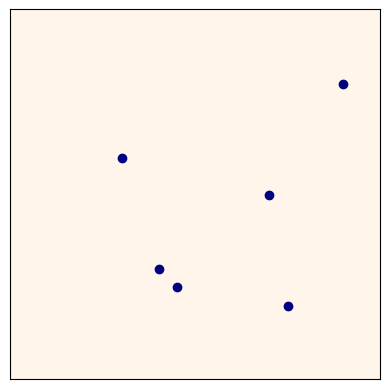

In [2]:
d = 2   # dimension of the data points

# First dataset with 6 points
n = 6
y = torch.zeros((n,d), device=device)
y[0, 0] = 0.9
y[0, 1] = 0.2
y[1, 0] = 0.75
y[1, 1] = 0.8
y[2, 0] = 0.3
y[2, 1] = 0.4
y[3, 0] = 0.4
y[3, 1] = 0.7
y[4, 0] = 0.45
y[4, 1] = 0.75
y[5, 0] = 0.7
y[5, 1] = 0.5

# # Second dataset with 100 points
# n = 100
# t = torch.pi*torch.linspace(-.2,1.2,n)
# y = .05*torch.randn((n,d))
# y[:,0] += torch.cos(t)
# y[:,1] += torch.sin(2*t)
# y = .5 + .3*y
# y = y.to(device)

# Define masses (empirical measure on the data points)
nu = torch.ones(n, device=device)/n

# generate grid for plotting purpose
nr,nc = 256,256
extent = ((-0.5/nc, 1-0.5/nc, 1-0.5/nr, -0.5/nr))
xs = torch.linspace(0, 1, steps=nr)
ys = torch.linspace(0, 1, steps=nc)
xm, ym = torch.meshgrid(xs, ys, indexing='ij')
xm = xm.T
ym = ym.T
xgrid = torch.cat((xm.reshape(nr*nc,1),ym.reshape(nr*nc,1)),1).to(device)

# Plot data points
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

## Define Generator architecture

QUESTION: Examine the layers and parameters of the following generative network.

Write a short description of the architecture of this network.

1. **Initialization Parameters:**
   - `n_in`: Number of input features.
   - `n_out`: Number of output features.
   - `n_hid`: Number of neurons in each hidden layer, defaulting to 10.
   - `nlayers`: Total number of hidden layers in the network, defaulting to 3.
   - `device`: The computing device (CPU or GPU) where the network will be run, defaulting to CPU.

2. **Network Layers:**
   - The network consists of a sequence of hidden layers defined by `nlayers`. Each hidden layer is constructed dynamically in a loop during initialization.
     - For the first layer, the input size is `n_in`.
     - For subsequent layers, the input size is `n_hid`, the size of the previous hidden layer.
     - Each layer in the hidden sequence (`self.hidden`) is a `nn.Sequential` module containing:
       - A linear transformation (`nn.Linear`) that connects the input to the hidden units.
       - An Exponential Linear Unit (`nn.ELU`) activation function with alpha parameter set to 1, to introduce non-linearity.
   - The output layer (`self.out`) is also a `nn.Sequential` module containing:
     - A linear transformation that maps the last hidden layer to the output size `n_out`.
     - A sigmoid activation function (`nn.Sigmoid`) to ensure the output values are between 0 and 1.

3. **Weight Initialization:**
   - The method `_init_weights` is applied to all modules upon initialization. It configures the weights and biases of the linear layers:
     - Weights are initialized using the Xavier uniform initialization, which is suited for networks with ELU activations.
     - Biases are initialized to zero.

4. **Forward Pass:**
   - The `forward` method defines how the input data `x` is processed through the network:
     - The data passes sequentially through each hidden layer.
     - After the final hidden layer, the data is processed by the output layer to produce the final output.

In [3]:
class Generator(torch.nn.Module):

    def __init__(self, n_in, n_out, n_hid=10, nlayers=3, device=torch.device("cpu")):
        super(Generator, self).__init__()

        self.n_in = n_in
        self.n_out = n_out
        self.n_hid = n_hid
        self.nlayers = nlayers
        self.hidden = nn.ModuleList()

        for n in range(nlayers):
            n_in_t = n_in if n==0 else n_hid
            self.hidden.append(nn.Sequential(
            nn.Linear(n_in_t, n_hid),
            nn.ELU(1)
        ).to(device))

        self.out = nn.Sequential(
            nn.Linear(n_hid, n_out),
            nn.Sigmoid()
        ).to(device)

        self.apply(self._init_weights)


    def forward(self, x):
        for n in range(self.nlayers):
            x = self.hidden[n](x)
        x = self.out(x)
        return x


    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight, 1.0)
            if module.bias is not None:
                module.bias.data.zero_()


QUESTION: Plot one initial configuration of the generator (draw a batch of generated points)

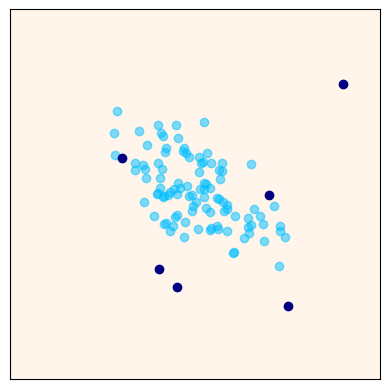

In [4]:
torch.manual_seed(0)  # initialize random seed for reproducibility

n_in = 10    # dimension of the input noise
b = 100      # batch size

# Initialize generator
G = Generator(n_in=n_in, n_out=d, n_hid=100, nlayers=3, device=device)

# Draw a batch x of generated points
#    Input noise z : standard normal with shape (b, n_in)

z = torch.randn(b, n_in, device=device)  # Generate normal distributed noise
x = G(z)  # Generate points

# Plot
xd = x.detach()
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

## Define Discriminator Architecture

In [5]:
class Discriminator(nn.Module):
  def __init__(self, n_in, n_hid=10):
    super(Discriminator, self).__init__()

    self.n_hid = n_hid
    self.n_in = n_in

    self.fc1 = nn.Linear(n_in, n_hid)
    self.fc2 = nn.Linear(n_hid, n_hid)
    self.fc3 = nn.Linear(n_hid, 1)

  def forward(self, x):
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc1(x))
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc2(y))
    y = self.fc3(y)
    return y

## Discriminator training with Weight clipping

QUESTION: For a fixed generator, train the discriminator with WGAN loss and weight clipping.

Try changing the clip_value. What do you observe?

[0/1000], -0.007124


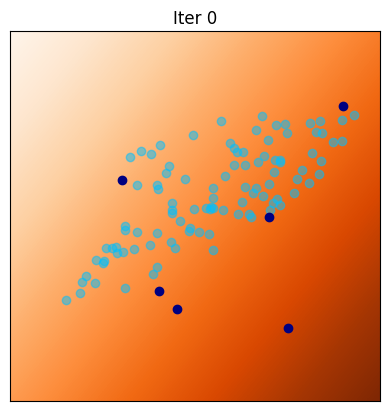

[100/1000], -0.006160


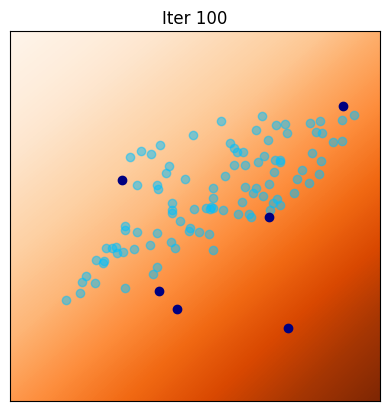

[200/1000], -0.007019


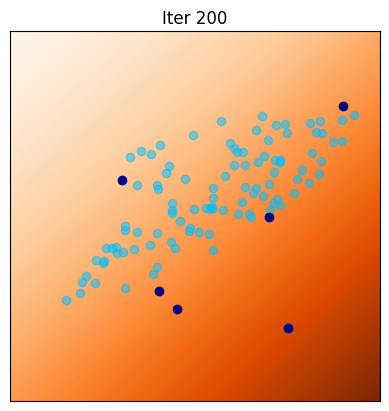

[300/1000], -0.006355


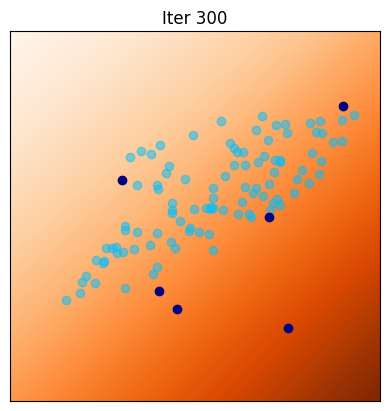

[400/1000], -0.006726


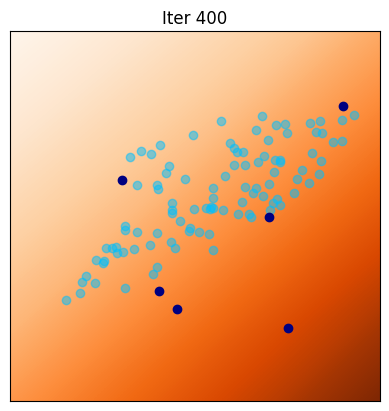

[500/1000], -0.005547


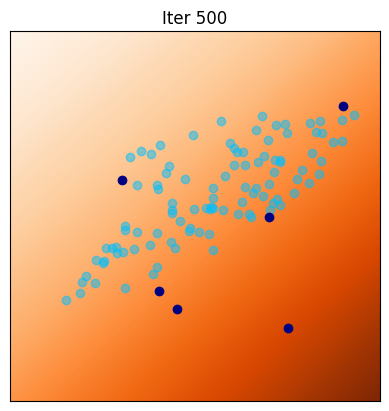

[600/1000], -0.007901


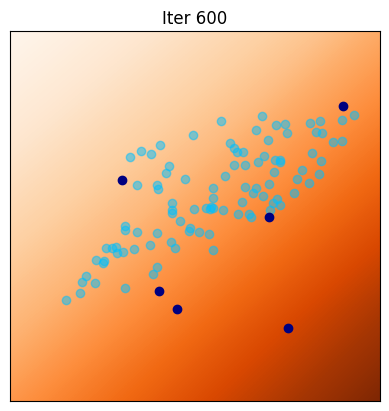

[700/1000], -0.007665


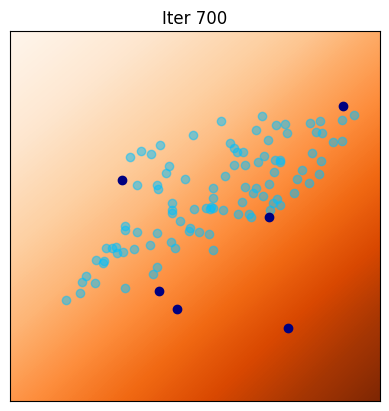

[800/1000], -0.008363


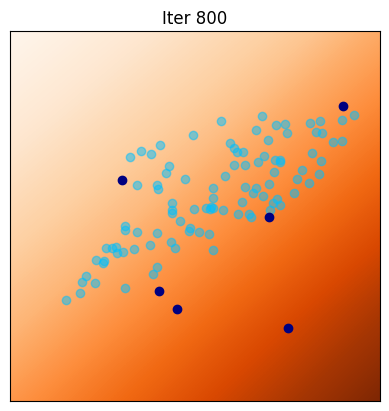

[900/1000], -0.007577


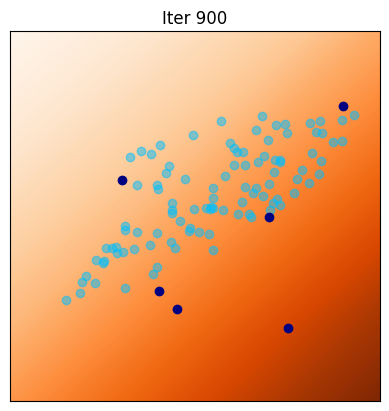

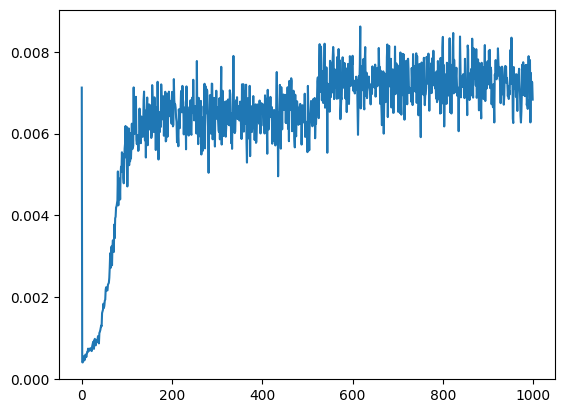

In [6]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# fix one generator
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)

# parameters for discriminator optimization
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
niterD=1000

clip_value = .1

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

iter_display = 100  # display current configuration each iter_display iteration

# Lists to keep track of progress
Dlosses = []

for iter in range(0,niterD):

    ### UPDATE OF D ###
    optimD.zero_grad()

    # Real data sample 
    real_data = y
    fake_data = G(torch.randn(b, n_in, device=device))

    # Calculate discriminator loss on real and fake data
    Dloss = D(fake_data).mean() - D(real_data).mean()

    # Backward and optimize
    Dloss.backward()  # Maximizing Dloss
    optimD.step()

    ### ... Weight Clipping ... ###
    for p in D.parameters():
        p.data.clamp_(-clip_value, clip_value)

    ### SAVE LOSS ###
    Dlosst = Dloss.item()
    Dlosses.append(-Dlosst)

    if(iter%iter_display == 0):
        print('[%d/%d], %f' % (iter, niterD, Dlosst))
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Iter '+str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()

plt.plot(Dlosses)

## Estimate the Lipschitz constant of the discriminator

The following function computes a lower bound of the Lipschitz constant of $D$ on points that are interpolated between $x$ and $y$.

NB: If $x$ and $y$ do not have the same number of points, we discard the last points.
In comment, we give an alternative code that allows to compute all segments $[x_i, y_j]$ (but it is, of course, slower that just computing segments $[x_i, y_i]$).

In [7]:
def lipconstant(D,x,y):
    b = x.shape[0]
    n = y.shape[0]
    # shrink vectors if they are too large
    if n>b:
        y = y[0:b,:]
        n = b
    else:
        x = x[0:n,:]
        b = n
    # compute interpolated points
    alpha = torch.rand((b,1),device=device)
    interp = alpha * y + (1 - alpha) * x
    interp.requires_grad_()

    # Calculate probability of interpolated examples
    Di = D(interp).view(-1)

    # Calculate gradients of probabilities with respect to examples
    gradout = torch.ones(Di.size()).to(device)
    gradients = torch.autograd.grad(outputs=Di, inputs=interp, grad_outputs=gradout,
       create_graph=True, retain_graph=True)[0]

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1))

    # Return gradient penalty
    return torch.mean(gradients_norm)

#     # Calculate interpolation
#     b = x.shape[0]
#     n = y.shape[0]
#     alpha = torch.rand((b,n,1),device=device)
#     interp = (alpha * y[None,:,:] + (1 - alpha) * x[:,None,:]).flatten(end_dim=1)
#     interp.requires_grad_()


QUESTION: Use this function to examine the Lipschitz constant of the final discriminator obtained above with weight clipping.


In [8]:
# Calculate the Lipschitz constant
lip_const = lipconstant(D, real_data, fake_data)
print("Estimated Lipschitz constant:", lip_const.item())


Estimated Lipschitz constant: 0.05784161761403084


## Gradient Penalty

QUESTION: Implement a function computing the gradient penalty of a discriminator $D$ on points $X$ that are randomly interpolated between $x$ and $y$:
$$ GP(D) = \mathbb{E}\left[ \Big(\|\nabla D(X)\| - 1 \Big)^2 \right] .$$
In pratice you will use
$$\|\nabla D(X)\| \approx \sqrt{\|\nabla D (X)\|_2^2 + 10^{-12} } $$
to avoid numerical instability.

In [9]:
def gradient_penalty(D,x,y):
    b = x.shape[0]
    n = y.shape[0]
    # shrink vectors if they are too large
    if n>b:
        y = y[0:b,:]
        n = b
    else:
        x = x[0:n,:]
        b = n
    # compute interpolated points
    alpha = torch.rand((b,1),device=device)
    interp = (alpha * y + (1 - alpha) * x)
    interp.requires_grad_()

#     # Calculate interpolation
#     b = x.shape[0]
#     n = y.shape[0]
#     alpha = torch.rand((b,n,1),device=device)
#     interp = (alpha * y[None,:,:] + (1 - alpha) * x[:,None,:]).flatten(end_dim=1)
#     interp.requires_grad_()

    # Calculate probability of interpolated examples
    Di = D(interp).view(-1)

    # Calculate gradients of probabilities with respect to examples
    gradout = torch.ones(Di.size()).to(device)
    gradients = torch.autograd.grad(outputs=Di, inputs=interp, grad_outputs=gradout,
       create_graph=True, retain_graph=True)[0]

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1))

    # Return gradient penalty
    return ((gradients_norm - 1) ** 2).mean()
#     return ((gradients_norm - 1) ** 2*(gradients_norm>1)).mean()

print(gradient_penalty(D,x,y))

tensor(0.8823, grad_fn=<MeanBackward0>)


## Discriminator training with Gradient Penalty

QUESTION: Complete the following code at the blocks ###...###.

Adjust the weight of the gradient penalty (parameter `gpw`) to get a Lipschitz constant $\approx 1$.

[0/1000], Dloss=8.5438, Lip(D)=0.0817


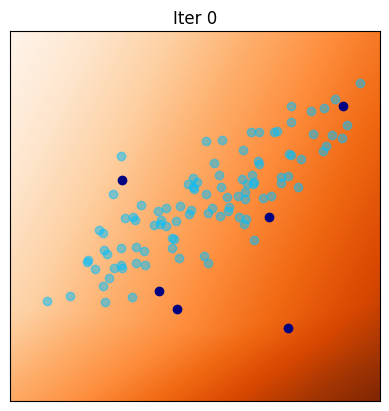

[100/1000], Dloss=-0.0112, Lip(D)=1.0004


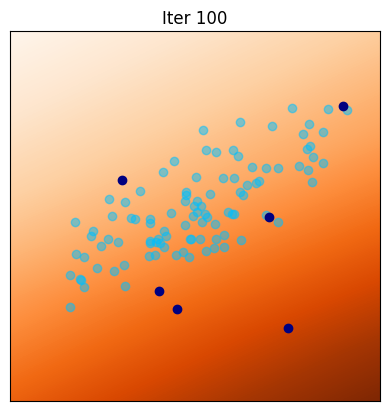

[200/1000], Dloss=-0.0366, Lip(D)=0.9962


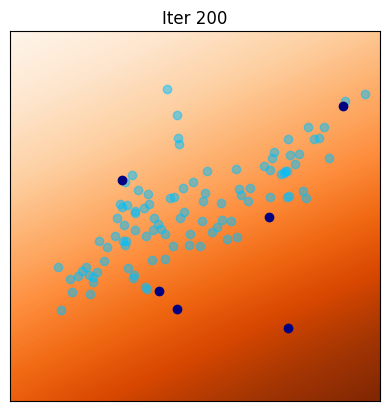

[300/1000], Dloss=-0.0914, Lip(D)=0.9812


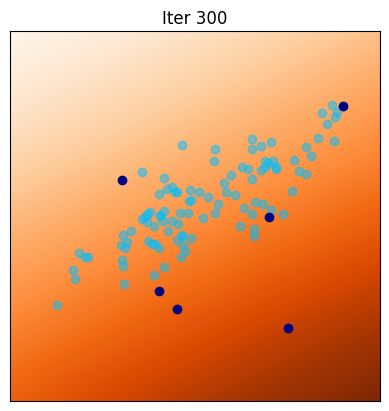

[400/1000], Dloss=-0.0925, Lip(D)=1.0080


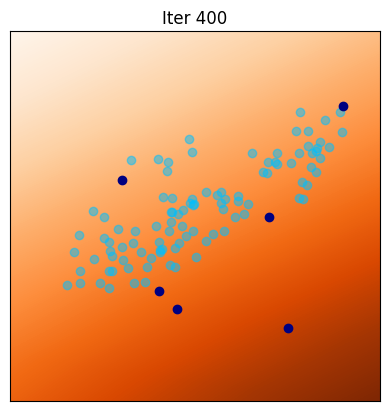

[500/1000], Dloss=-0.1187, Lip(D)=1.0118


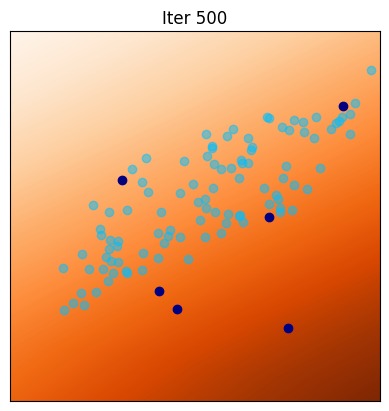

[600/1000], Dloss=-0.1134, Lip(D)=1.0032


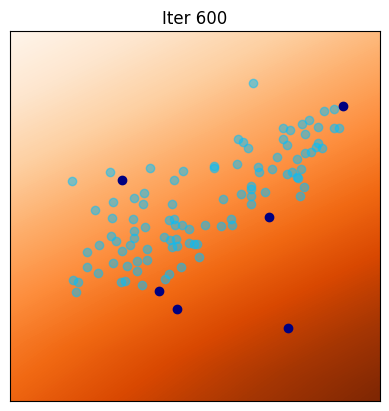

[700/1000], Dloss=-0.1195, Lip(D)=1.0042


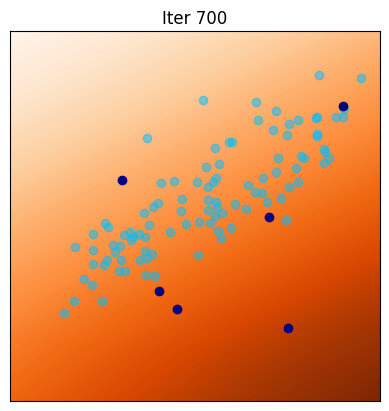

[800/1000], Dloss=-0.1289, Lip(D)=1.0081


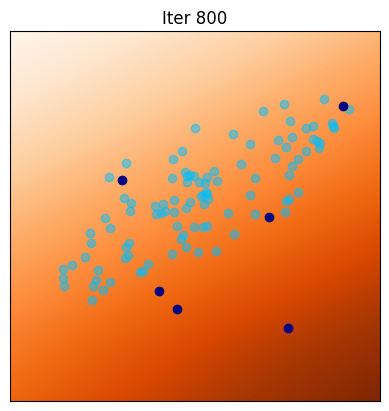

[900/1000], Dloss=-0.1204, Lip(D)=0.9985


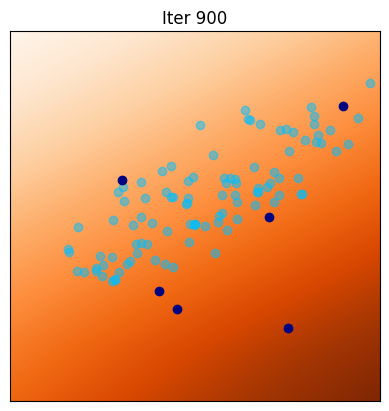

Final estimated Lipschitz constant =  1.0028959512710571


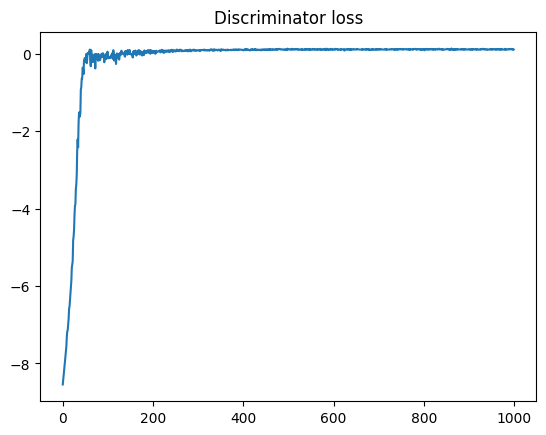

In [10]:
torch.manual_seed(1)  # Initialize random seed for reproducibility

# Assuming n_in, d, Generator, Discriminator are defined, and 'device' is set
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
D = Discriminator(n_in=d, n_hid=10).to(device)

# Parameters for training
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
niterD = 1000
gpw = 10  # Parameter for gradient penalty weight

optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

iter_display = 100  # Display current configuration each iter_display iteration

# Lists to keep track of progress
Dlosses = []

for iter in range(niterD):
    optimD.zero_grad()

    # Generate fake data
    z = torch.randn(b, n_in, device=device)
    fake_data = G(z)

    # Sample real data (assuming 'y' is available as a tensor of real data)
    real_data = y.to(device)

    # Compute discriminator loss on real and fake data
    real_loss = D(real_data).mean()
    fake_loss = D(fake_data).mean()
    D_loss = fake_loss - real_loss

    # Compute gradient penalty
    gd_penalty = gradient_penalty(D, real_data, fake_data) * gpw
    Dloss = D_loss + gd_penalty

    # Backward pass and optimize
    Dloss.backward()
    optimD.step()

    # Save loss
    Dlosst = Dloss.item()
    Dlosses.append(-Dlosst)

    if iter % iter_display == 0:
        lip_const = lipconstant(D, real_data, fake_data).item()
        print(f'[{iter}/{niterD}], Dloss={Dlosst:.4f}, Lip(D)={lip_const:.4f}')
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        xd = fake_data.detach().cpu()
        strtitle = f'Iter {iter}'
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid, cmap='Oranges', extent=extent)
        plt.scatter(xd[:, 0], xd[:, 1], c='deepskyblue', alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:, 1].cpu(), c='navy')
        plt.title(strtitle)
        plt.show()

print('Final estimated Lipschitz constant = ', lipconstant(D, real_data, fake_data).item())

plt.figure(dpi=100)
plt.plot(Dlosses)
plt.title('Discriminator loss')
plt.show()

## WGAN-GP training

QUESTION: Complete the following code in order to train simultaneously the generator and discriminator.

You will alternate `niterD` iterations on the discriminator and `niterG` iterations of the discriminator.

[1/100] 	Loss_D: -0.1784	Loss_G: -1.6617	Lip(D)=1.5978
[2/100] 	Loss_D: -0.1468	Loss_G: -0.9558	Lip(D)=1.6810
[3/100] 	Loss_D: -0.1932	Loss_G: -2.4653	Lip(D)=1.2835
[4/100] 	Loss_D: -0.0968	Loss_G: -4.8134	Lip(D)=1.3879
[5/100] 	Loss_D: -0.0511	Loss_G: -9.4176	Lip(D)=1.2139


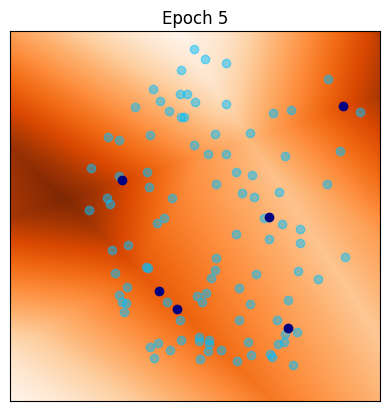

[6/100] 	Loss_D: -0.1399	Loss_G: -12.2933	Lip(D)=1.7589
[7/100] 	Loss_D: -0.0981	Loss_G: -13.6363	Lip(D)=1.2666
[8/100] 	Loss_D: -0.0734	Loss_G: -16.0561	Lip(D)=1.5958
[9/100] 	Loss_D: -0.1396	Loss_G: -18.4249	Lip(D)=1.4336
[10/100] 	Loss_D: -0.1200	Loss_G: -20.4923	Lip(D)=1.4936


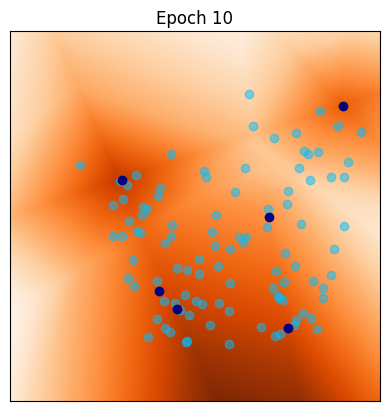

[11/100] 	Loss_D: -0.1796	Loss_G: -21.1936	Lip(D)=1.4043
[12/100] 	Loss_D: -0.1005	Loss_G: -21.1144	Lip(D)=1.6374
[13/100] 	Loss_D: -0.1381	Loss_G: -21.9780	Lip(D)=1.5409
[14/100] 	Loss_D: -0.1508	Loss_G: -24.2205	Lip(D)=1.4543
[15/100] 	Loss_D: -0.1577	Loss_G: -24.0047	Lip(D)=1.5227


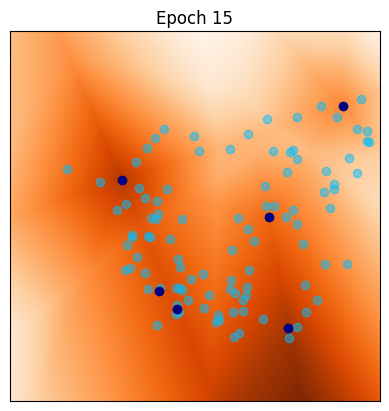

[16/100] 	Loss_D: -0.1049	Loss_G: -24.3816	Lip(D)=1.5620
[17/100] 	Loss_D: -0.1333	Loss_G: -27.3970	Lip(D)=1.6241
[18/100] 	Loss_D: -0.1034	Loss_G: -29.5870	Lip(D)=1.5884
[19/100] 	Loss_D: -0.1049	Loss_G: -30.1714	Lip(D)=1.2874
[20/100] 	Loss_D: -0.1216	Loss_G: -30.7136	Lip(D)=1.3516


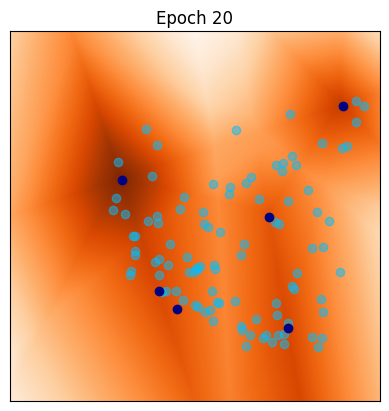

[21/100] 	Loss_D: -0.1156	Loss_G: -30.9789	Lip(D)=1.4660
[22/100] 	Loss_D: -0.1260	Loss_G: -32.8159	Lip(D)=1.4446
[23/100] 	Loss_D: -0.1100	Loss_G: -34.7709	Lip(D)=1.3133
[24/100] 	Loss_D: -0.1245	Loss_G: -35.2014	Lip(D)=1.3893
[25/100] 	Loss_D: -0.0942	Loss_G: -35.6673	Lip(D)=1.3578


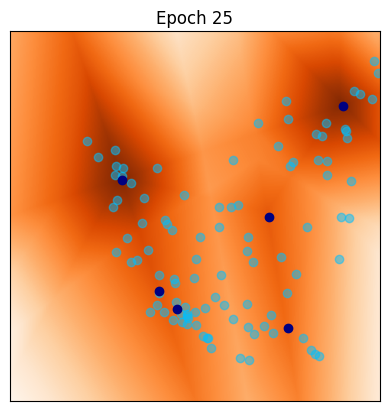

[26/100] 	Loss_D: -0.1096	Loss_G: -37.1919	Lip(D)=1.3563
[27/100] 	Loss_D: -0.0907	Loss_G: -37.2553	Lip(D)=1.3320
[28/100] 	Loss_D: -0.0734	Loss_G: -41.9660	Lip(D)=1.1858
[29/100] 	Loss_D: -0.1007	Loss_G: -45.7475	Lip(D)=1.4613
[30/100] 	Loss_D: -0.0837	Loss_G: -47.0869	Lip(D)=1.3958


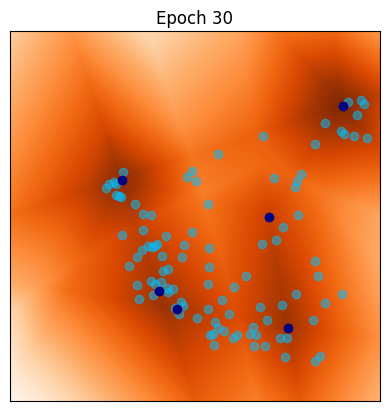

[31/100] 	Loss_D: -0.0726	Loss_G: -49.4032	Lip(D)=1.4891
[32/100] 	Loss_D: -0.1179	Loss_G: -51.8088	Lip(D)=1.2478
[33/100] 	Loss_D: -0.0868	Loss_G: -51.7271	Lip(D)=1.3932
[34/100] 	Loss_D: -0.0869	Loss_G: -51.7567	Lip(D)=1.2309
[35/100] 	Loss_D: -0.1135	Loss_G: -54.3220	Lip(D)=1.2925


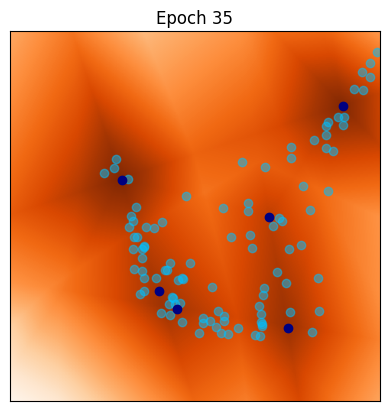

[36/100] 	Loss_D: -0.0920	Loss_G: -55.5270	Lip(D)=1.4770
[37/100] 	Loss_D: -0.0667	Loss_G: -57.2676	Lip(D)=1.4052
[38/100] 	Loss_D: -0.0786	Loss_G: -55.8569	Lip(D)=1.1901
[39/100] 	Loss_D: -0.0922	Loss_G: -57.5805	Lip(D)=1.3197
[40/100] 	Loss_D: -0.0832	Loss_G: -55.6862	Lip(D)=1.2111


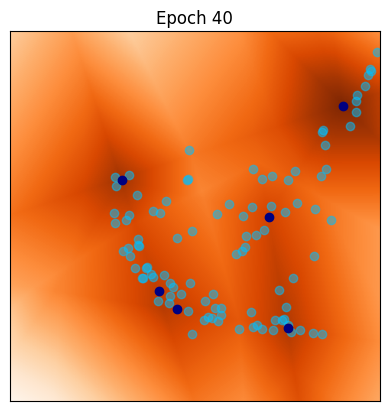

[41/100] 	Loss_D: -0.1053	Loss_G: -54.7628	Lip(D)=1.4603
[42/100] 	Loss_D: -0.1062	Loss_G: -57.1330	Lip(D)=1.3492
[43/100] 	Loss_D: -0.1010	Loss_G: -56.2889	Lip(D)=1.1251
[44/100] 	Loss_D: -0.1160	Loss_G: -60.4075	Lip(D)=1.3559
[45/100] 	Loss_D: -0.0639	Loss_G: -56.4112	Lip(D)=1.2190


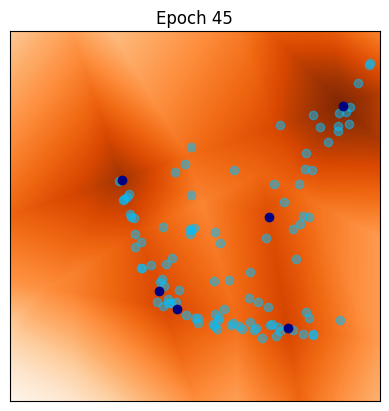

[46/100] 	Loss_D: -0.0887	Loss_G: -51.9015	Lip(D)=1.4924
[47/100] 	Loss_D: -0.1000	Loss_G: -52.3821	Lip(D)=1.2785
[48/100] 	Loss_D: -0.0929	Loss_G: -58.0002	Lip(D)=1.3951
[49/100] 	Loss_D: -0.0926	Loss_G: -57.0758	Lip(D)=1.5242
[50/100] 	Loss_D: -0.0739	Loss_G: -52.8252	Lip(D)=1.4207


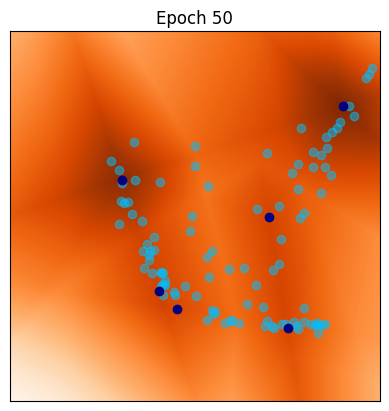

[51/100] 	Loss_D: -0.1047	Loss_G: -54.5403	Lip(D)=1.2113
[52/100] 	Loss_D: -0.0855	Loss_G: -55.9452	Lip(D)=1.2649
[53/100] 	Loss_D: -0.0949	Loss_G: -55.7790	Lip(D)=1.2552
[54/100] 	Loss_D: -0.0979	Loss_G: -54.9564	Lip(D)=1.3633
[55/100] 	Loss_D: -0.0946	Loss_G: -49.2105	Lip(D)=1.1769


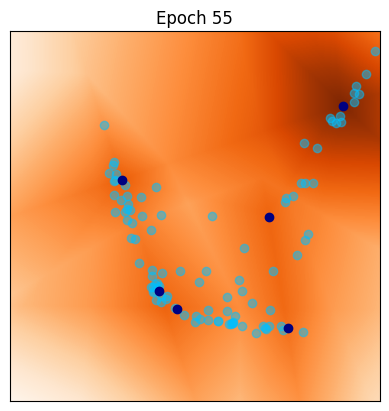

[56/100] 	Loss_D: -0.0764	Loss_G: -49.5574	Lip(D)=1.2568
[57/100] 	Loss_D: -0.0473	Loss_G: -45.5146	Lip(D)=1.3902
[58/100] 	Loss_D: -0.0748	Loss_G: -45.3377	Lip(D)=1.3302
[59/100] 	Loss_D: -0.1123	Loss_G: -42.8331	Lip(D)=1.3613
[60/100] 	Loss_D: -0.1029	Loss_G: -50.2755	Lip(D)=1.4148


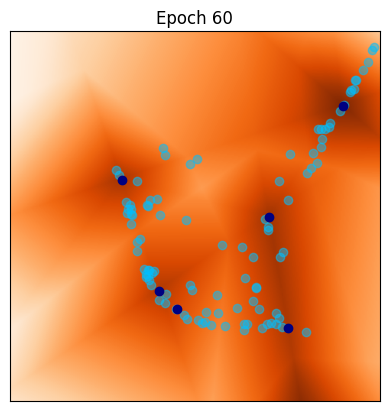

[61/100] 	Loss_D: -0.0940	Loss_G: -52.2239	Lip(D)=1.5597
[62/100] 	Loss_D: -0.0780	Loss_G: -48.8907	Lip(D)=1.4453
[63/100] 	Loss_D: -0.0862	Loss_G: -52.0514	Lip(D)=1.4794
[64/100] 	Loss_D: -0.0930	Loss_G: -54.9922	Lip(D)=1.3973
[65/100] 	Loss_D: -0.0844	Loss_G: -51.0466	Lip(D)=1.4644


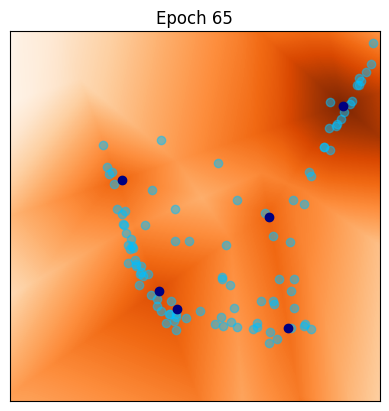

[66/100] 	Loss_D: -0.0929	Loss_G: -51.0968	Lip(D)=1.4196
[67/100] 	Loss_D: -0.1077	Loss_G: -49.7996	Lip(D)=1.4014
[68/100] 	Loss_D: -0.0655	Loss_G: -51.7882	Lip(D)=1.4620
[69/100] 	Loss_D: -0.0695	Loss_G: -51.1320	Lip(D)=1.2673
[70/100] 	Loss_D: -0.0923	Loss_G: -50.2829	Lip(D)=1.3155


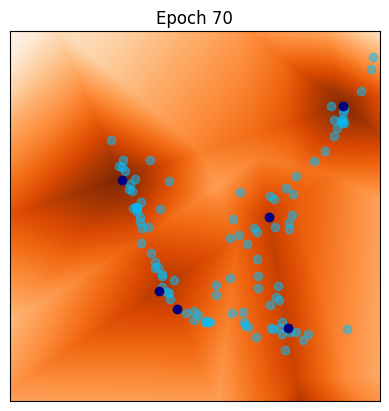

[71/100] 	Loss_D: -0.0915	Loss_G: -47.4591	Lip(D)=1.3970
[72/100] 	Loss_D: -0.1190	Loss_G: -59.6476	Lip(D)=1.4598
[73/100] 	Loss_D: -0.0778	Loss_G: -53.6720	Lip(D)=1.3473
[74/100] 	Loss_D: -0.0885	Loss_G: -53.3778	Lip(D)=1.3456
[75/100] 	Loss_D: -0.0415	Loss_G: -48.9328	Lip(D)=1.3375


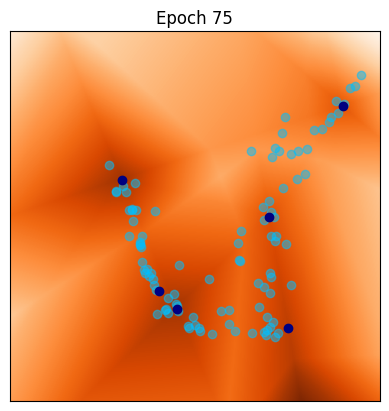

[76/100] 	Loss_D: -0.0949	Loss_G: -45.7033	Lip(D)=1.3092
[77/100] 	Loss_D: -0.0759	Loss_G: -40.0883	Lip(D)=1.2545
[78/100] 	Loss_D: -0.0915	Loss_G: -60.9821	Lip(D)=1.1870
[79/100] 	Loss_D: -0.0984	Loss_G: -59.3786	Lip(D)=1.1779
[80/100] 	Loss_D: -0.0715	Loss_G: -60.5315	Lip(D)=1.3706


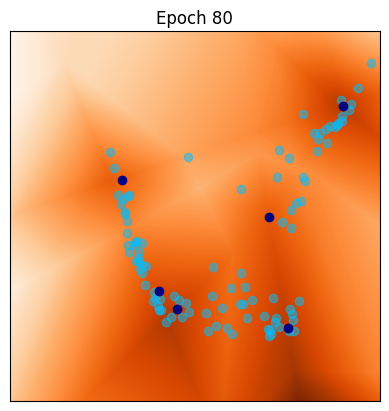

[81/100] 	Loss_D: -0.0817	Loss_G: -50.7382	Lip(D)=1.0738
[82/100] 	Loss_D: -0.0574	Loss_G: -49.0094	Lip(D)=1.0444
[83/100] 	Loss_D: -0.0725	Loss_G: -42.6336	Lip(D)=1.5330
[84/100] 	Loss_D: -0.0883	Loss_G: -56.5033	Lip(D)=1.0378
[85/100] 	Loss_D: -0.0746	Loss_G: -54.7216	Lip(D)=1.4355


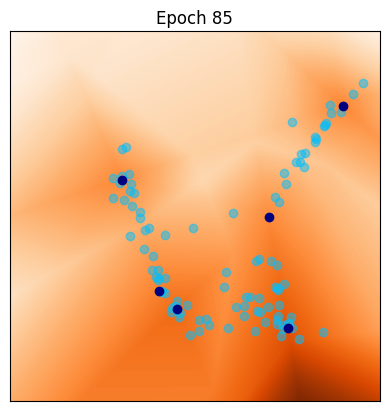

[86/100] 	Loss_D: -0.0573	Loss_G: -47.1578	Lip(D)=1.2341
[87/100] 	Loss_D: -0.0722	Loss_G: -53.6397	Lip(D)=1.4070
[88/100] 	Loss_D: -0.0710	Loss_G: -56.3596	Lip(D)=1.3034
[89/100] 	Loss_D: -0.0951	Loss_G: -57.8897	Lip(D)=1.2562
[90/100] 	Loss_D: -0.0882	Loss_G: -64.9882	Lip(D)=1.4858


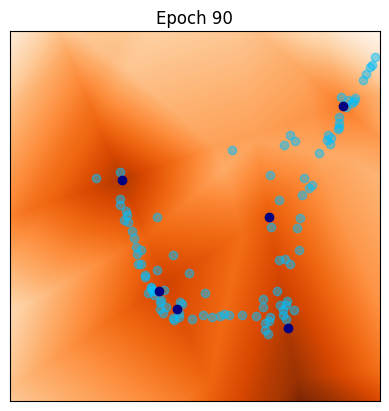

[91/100] 	Loss_D: -0.0530	Loss_G: -56.6488	Lip(D)=1.4540
[92/100] 	Loss_D: -0.0747	Loss_G: -55.8295	Lip(D)=1.4315
[93/100] 	Loss_D: -0.0547	Loss_G: -61.9506	Lip(D)=1.3797
[94/100] 	Loss_D: -0.0965	Loss_G: -62.2889	Lip(D)=1.6925
[95/100] 	Loss_D: -0.1054	Loss_G: -61.6640	Lip(D)=1.4265


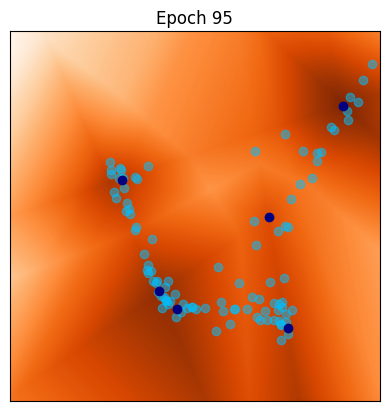

[96/100] 	Loss_D: -0.0749	Loss_G: -50.0670	Lip(D)=1.2326
[97/100] 	Loss_D: -0.1062	Loss_G: -66.4636	Lip(D)=1.4327
[98/100] 	Loss_D: -0.0554	Loss_G: -49.0156	Lip(D)=1.3165
[99/100] 	Loss_D: -0.1051	Loss_G: -49.2197	Lip(D)=1.3137


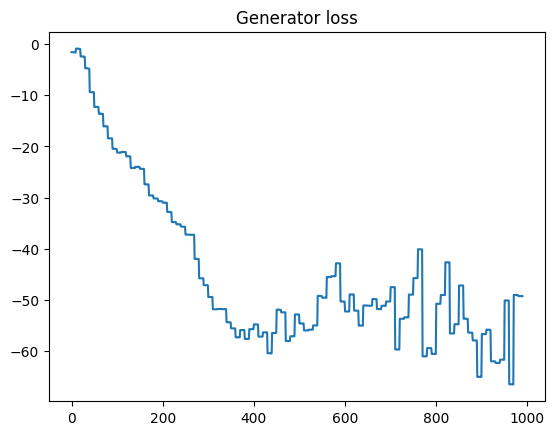

<All keys matched successfully>

In [11]:
## parameters for training
n_epochs = 100
niterD=1000
niterG=10
gpw = .1

lr = 0.002      # learning rate for generator
lrdisc = 0.002  # learning rate for discriminator
beta_1 = 0.5
beta_2 = 0.999

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))


Glosses = []
Dlosses = []

iter_display = 5

# Main loop
for epoch in range(1,n_epochs):

    ############################
    ### Train discriminator (niterD iterations)
    ############################

    for iter in range(0,niterD):
        optimD.zero_grad()

        # Sample data
        real_data = y.to(device)  # Assuming 'y' is a batch of real data
        z = torch.randn(b, n_in, device=device)
        fake_data = G(z).detach()  # Detach to avoid training G on these labels

        # Calculate discriminator loss on real and fake data
        real_loss = D(real_data).mean()
        fake_loss = D(fake_data).mean()
        D_loss = fake_loss - real_loss

        # Compute gradient penalty
        gd_penalty = gradient_penalty(D, real_data, fake_data) * gpw
        Dloss = D_loss + gd_penalty

        Dloss.backward()
        optimD.step()

        Dlosses.append(-Dloss.item())

    ############################
    ### Train generator (niterG iterations)
    ############################
    for iter in range(0,niterG):
        optimG.zero_grad()

        # Generate fake data
        z = torch.randn(b, n_in, device=device)
        fake_data = G(z)

        # Calculate loss on fake data
        Gloss = -D(fake_data).mean()

        Gloss.backward()
        optimG.step()

        Glosses.append(Gloss.item())

    # Output training stats
    print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f\tLip(D)=%.4f'
      % (epoch, n_epochs, Dloss.item(), Gloss.item(),lipconstant(D,x,y).item()))

    if(epoch % iter_display == 0):
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        z = torch.randn(b, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Epoch '+str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()


plt.figure(dpi=100)
plt.plot(Glosses)
plt.title('Generator loss')
plt.show()

# Save final generator for later use
wgan = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
wgan.load_state_dict(G.state_dict())

## Sensitivy to hyper-parameters

QUESTION: Repeat the WGAN learning experiment, by changing the parameters of the optimization (learning rates, number of updates of D and G, etc).

From your experiments, can you draw a few recommendations for stable training?

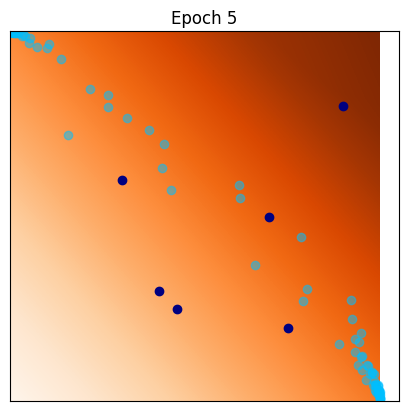

Epoch 10/100 	 Loss_D: -0.4027 	 Loss_G: -7.9852


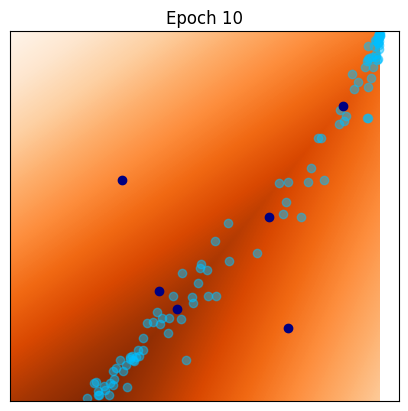

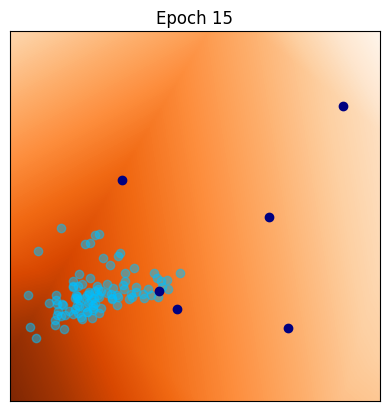

Epoch 20/100 	 Loss_D: -0.1046 	 Loss_G: -14.8564


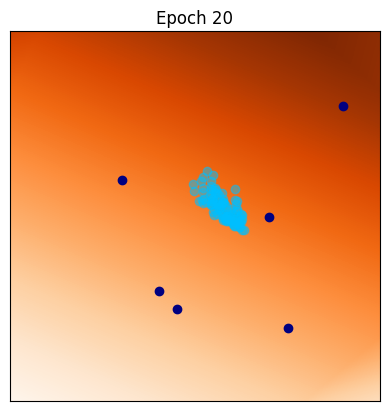

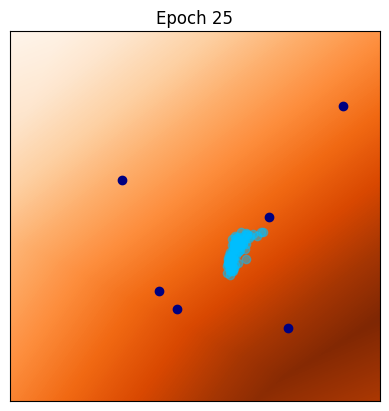

Epoch 30/100 	 Loss_D: -0.0685 	 Loss_G: -20.9480


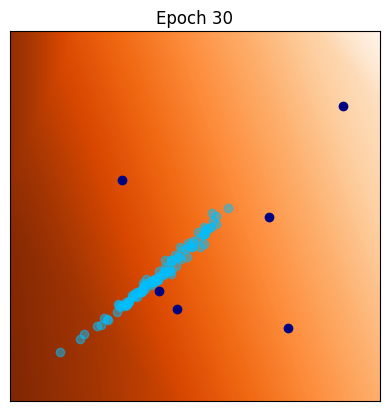

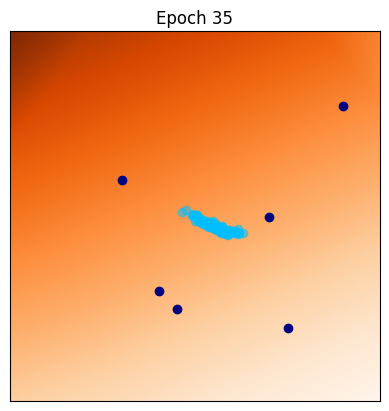

Epoch 40/100 	 Loss_D: -0.1947 	 Loss_G: -40.3038


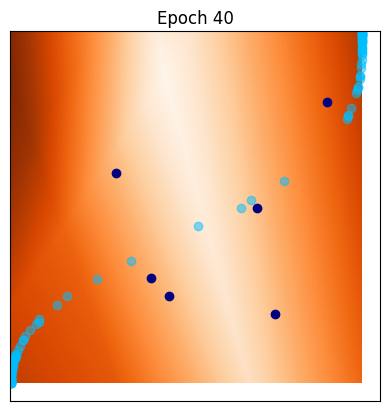

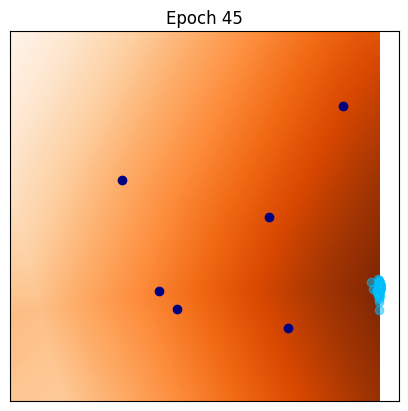

Epoch 50/100 	 Loss_D: -0.4596 	 Loss_G: -26.1912


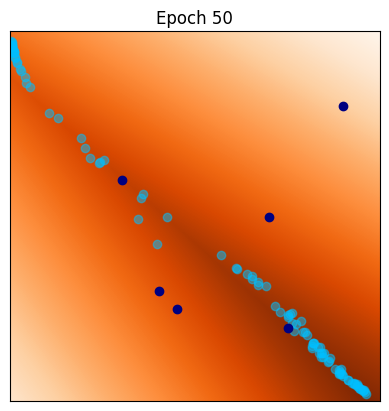

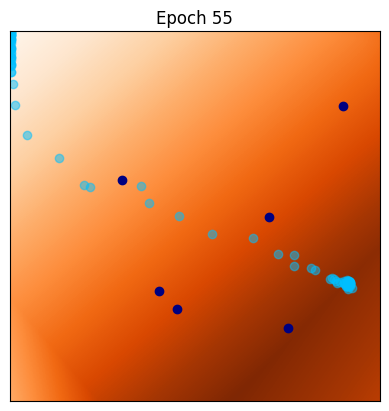

Epoch 60/100 	 Loss_D: -0.4694 	 Loss_G: -17.9712


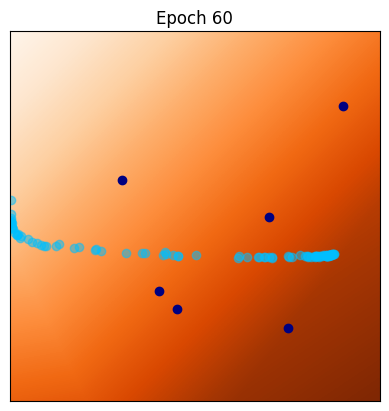

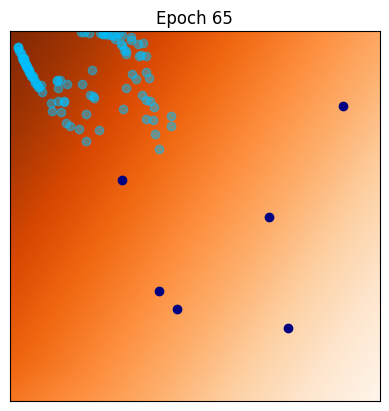

Epoch 70/100 	 Loss_D: -0.5110 	 Loss_G: -25.8351


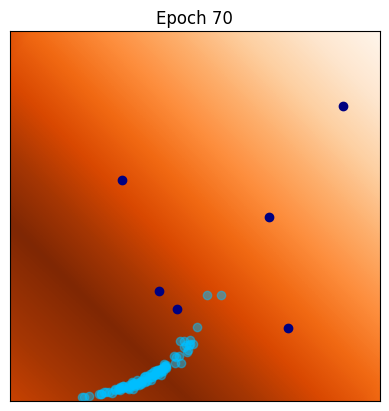

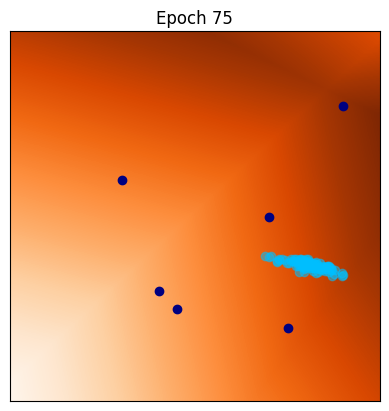

Epoch 80/100 	 Loss_D: -0.1643 	 Loss_G: -33.9257


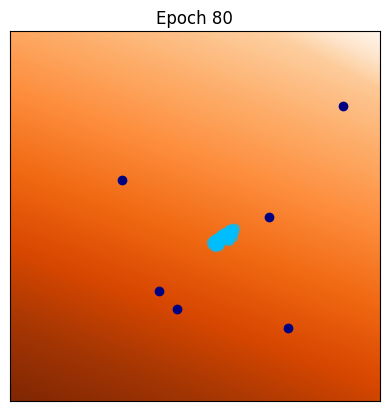

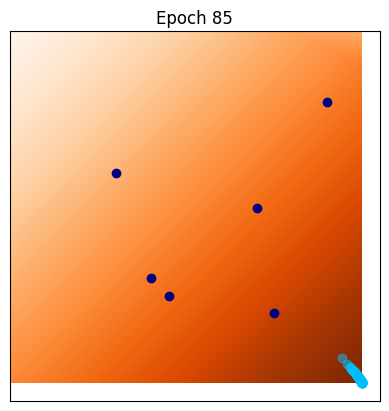

Epoch 90/100 	 Loss_D: -0.4013 	 Loss_G: -35.2124


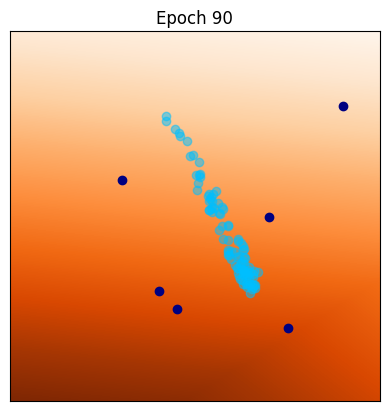

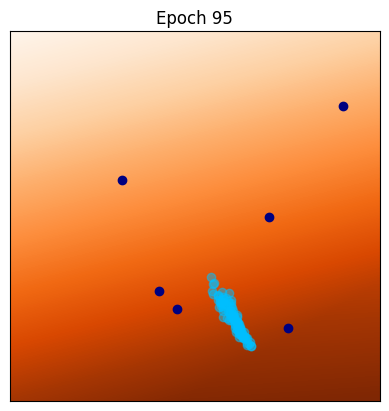

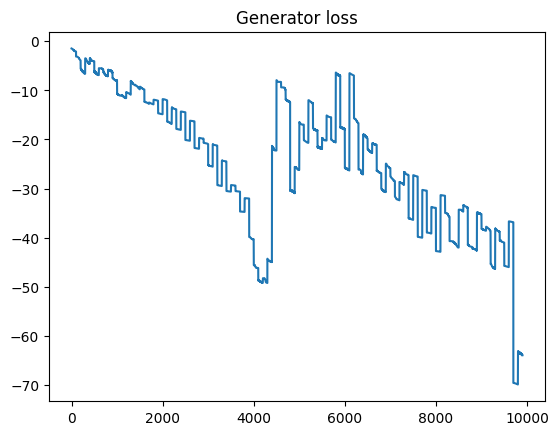

<All keys matched successfully>

In [12]:
torch.manual_seed(1)  # Initialize random seed for reproducibility

# Hyperparameters
n_epochs = 100
niterD = 1000     # Number of discriminator updates per loop
niterG = 100     # Number of generator updates per loop
gpw = 10       # Gradient penalty weight
lrD = 0.002    # Learning rate for discriminator
lrG = 0.002    # Learning rate for generator

# Initialize models
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device).to(device)
D = Discriminator(n_in=d, n_hid=10).to(device)

# Optimizers
optimG = optim.Adam(G.parameters(), lr=lrG)
optimD = optim.Adam(D.parameters(), lr=lrD, betas=(0.5, 0.999))

Glosses = []
Dlosses = []

iter_display = 5

# Training loop
for epoch in range(1, n_epochs):

    for iter in range(0, niterD):
        optimD.zero_grad()

        # Generate fake data
        z = torch.randn(b, n_in, device=device)
        fake_data = G(z)

        # Discriminator loss
        real_loss = D(real_data).mean()
        fake_loss = D(fake_data).mean()
        d_loss = fake_loss - real_loss

        # Gradient penalty
        penalty = gradient_penalty(D, real_data, fake_data) * gpw
        d_loss_total = d_loss + penalty

        d_loss_total.backward()
        optimD.step()

        Dlosses.append(-d_loss_total.item())

    ############################
    ### Train generator
    ############################
    for iter in range(0, niterG):
        optimG.zero_grad()

        # Regenerate fake data
        z = torch.randn(b, n_in, device=device)
        fake_data = G(z)

        # Generator loss
        g_loss = -D(fake_data).mean()

        g_loss.backward()
        optimG.step()

        Glosses.append(g_loss.item())

    # Output training stats
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{n_epochs} \t Loss_D: {d_loss_total.item():.4f} \t Loss_G: {g_loss.item():.4f}')

    if epoch % iter_display == 0:
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr, nc)
        z = torch.randn(b, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Epoch ' + str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid, cmap='Oranges', extent=extent)
        plt.scatter(xd[:, 0].cpu(), xd[:, 1].cpu(), c='deepskyblue', alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:, 1].cpu(), c='navy')
        plt.title(strtitle)
        plt.show()

plt.figure(dpi=100)
plt.plot(Glosses)
plt.title('Generator loss')
plt.show()

# Save final generator for later use
wgan = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
wgan.load_state_dict(G.state_dict())

## Train the generator only

QUESTION: For a fixed discriminator, optimize only the generator only. Can you explain what is happening then?

Epoch 10/1000 	 Loss_G: 0.0251
Epoch 20/1000 	 Loss_G: 0.0196
Epoch 30/1000 	 Loss_G: 0.0170
Epoch 40/1000 	 Loss_G: 0.0139
Epoch 50/1000 	 Loss_G: 0.0093
Epoch 60/1000 	 Loss_G: 0.0051
Epoch 70/1000 	 Loss_G: 0.0050
Epoch 80/1000 	 Loss_G: 0.0014
Epoch 90/1000 	 Loss_G: -0.0008
Epoch 100/1000 	 Loss_G: -0.0014
Epoch 110/1000 	 Loss_G: -0.0014
Epoch 120/1000 	 Loss_G: -0.0015
Epoch 130/1000 	 Loss_G: -0.0016
Epoch 140/1000 	 Loss_G: -0.0016
Epoch 150/1000 	 Loss_G: -0.0016
Epoch 160/1000 	 Loss_G: -0.0016
Epoch 170/1000 	 Loss_G: -0.0016
Epoch 180/1000 	 Loss_G: -0.0017
Epoch 190/1000 	 Loss_G: -0.0017
Epoch 200/1000 	 Loss_G: -0.0016
Epoch 210/1000 	 Loss_G: -0.0017
Epoch 220/1000 	 Loss_G: -0.0017
Epoch 230/1000 	 Loss_G: -0.0017
Epoch 240/1000 	 Loss_G: -0.0017
Epoch 250/1000 	 Loss_G: -0.0017
Epoch 260/1000 	 Loss_G: -0.0017
Epoch 270/1000 	 Loss_G: -0.0017
Epoch 280/1000 	 Loss_G: -0.0017
Epoch 290/1000 	 Loss_G: -0.0017
Epoch 300/1000 	 Loss_G: -0.0017
Epoch 310/1000 	 Loss_G: -0

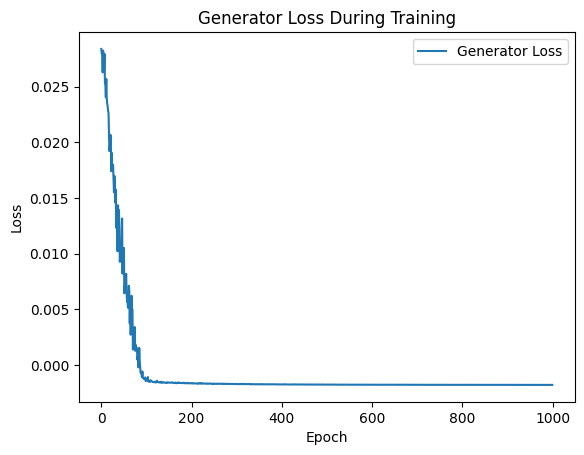

In [13]:
# Initialize the generator and discriminator
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device).to(device)
D = Discriminator(n_in=d, n_hid=10).to(device)

D.eval()  # Set the discriminator to evaluation mode to disable training

# Optimizer for the generator
optimG = optim.Adam(G.parameters(), lr=lrG)

n_epochs = 1000  # Number of epochs for generator training
lr = 0.001       # Learning rate for the generator
b = 64           # Batch size for generator training

# List to track the loss of the generator
losses = []

# Training loop for the generator
for epoch in range(1, n_epochs + 1):
    z = torch.randn(b, n_in, device=device)
    
    # Generate fake data and compute loss
    fake_data = G(z)
    Gloss = -D(fake_data).mean()  # We maximize the discriminator's error

    # Perform backpropagation
    optimG.zero_grad()
    Gloss.backward() 
    optimG.step()

    losses.append(Gloss.item())  # Store the loss from this epoch

    # Output training stats
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{n_epochs} \t Loss_G: {Gloss.item():.4f}')

# Plotting the generator loss
plt.figure(dpi=100)
plt.plot(losses, label='Generator Loss')
plt.title('Generator Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

<br/><br/><br/><br/>

# BONUS Exercise (to do at home) : Learn a standard GAN

## Define Loss for GAN training

For stable GAN training uses the Binary cross-entropy loss which takes labeled data as input.

The data points $y$ should correspond to values $\approx 1$, whereas fake points $x$ should get values $\approx 0$.

We also introduce the sigmoid function. for displaying purpose: for GAN training, the discriminator values in $[0,1]$ will be obtained by applying after $D$.

In [14]:
criterion = nn.BCEWithLogitsLoss()
V1 = torch.full((n,1), 1. , dtype=torch.float, device=device)
V0 = torch.full((b,1), 0. , dtype=torch.float, device=device)

sig = nn.Sigmoid()

## Train the discriminator for a fixed generator

QUESTION: Complete the following code at the blocks ###...###

[0/1000], 1.384813


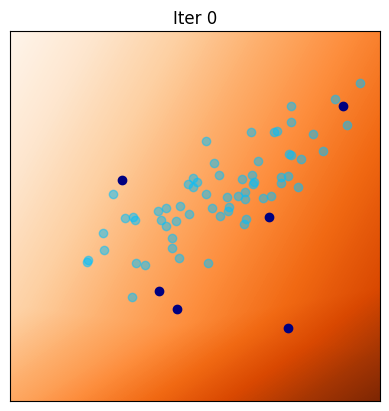

[100/1000], 1.219923


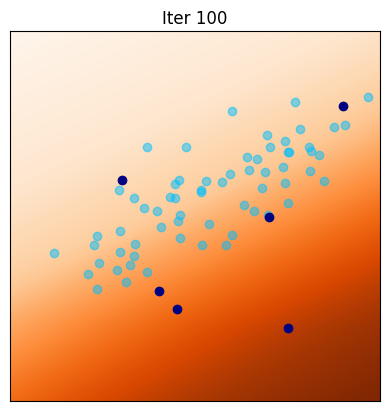

[200/1000], 1.111248


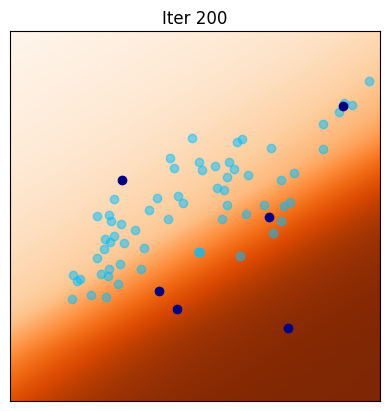

[300/1000], 1.050226


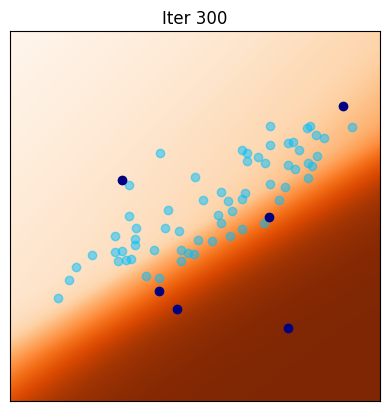

[400/1000], 0.909616


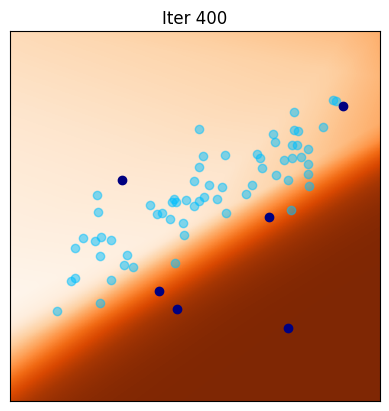

[500/1000], 0.823639


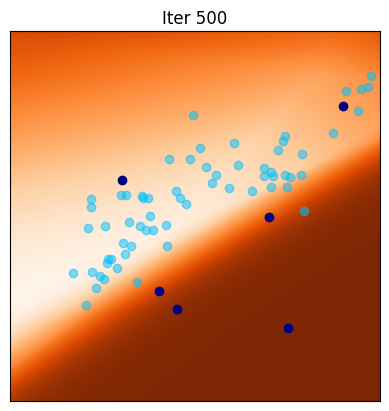

[600/1000], 0.739130


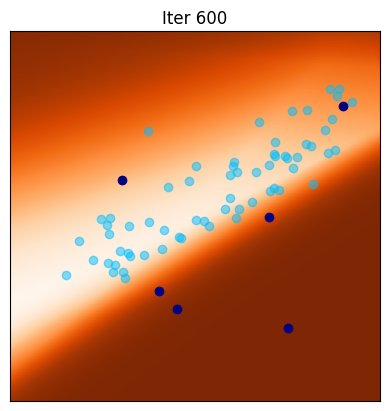

[700/1000], 0.747609


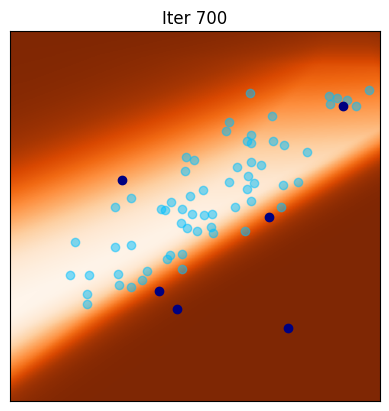

[800/1000], 0.581949


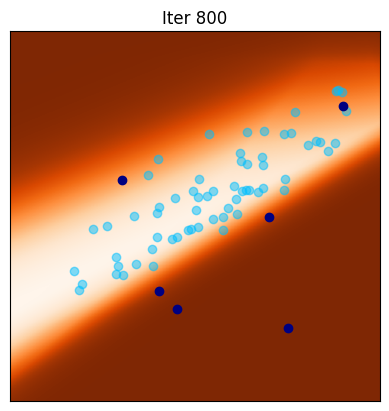

[900/1000], 0.562440


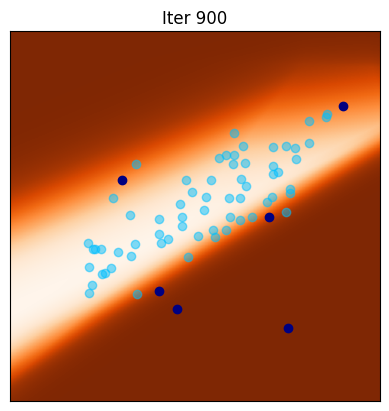

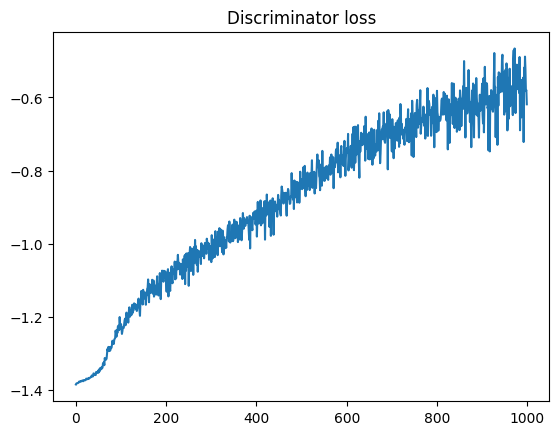

In [16]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# parameters for discriminator optimization
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
niterD=1000

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, 0.999))

iter_display = 100  # display current configuration each iter_display iteration

Dlosses = []

for iter in range(0,niterD):

    ### UPDATE OF D ###
    optimD.zero_grad()

    # Generate fake data
    z = torch.randn(b, n_in, device=device)
    fake_data = G(z)
    
    # Get real data
    real_data = y.to(device)  # Assuming 'y' is a tensor of real data

    # Calculate loss on real data
    real_output = D(real_data)
    D_loss_real = criterion(real_output, V1)

    # Calculate loss on fake data
    fake_output = D(fake_data.detach())  # Detach to avoid training generator
    D_loss_fake = criterion(fake_output, V0)

    # Combine losses
    Dloss = D_loss_real + D_loss_fake
    Dloss.backward()
    optimD.step()

    ### SAVE LOSS ###
    Dlosst = Dloss.item()
    Dlosses.append(-Dlosst)

    if(iter%iter_display == 0):
        print('[%d/%d], %f' % (iter, niterD, Dlosst))
        Dxgrid = sig(D(xgrid)).detach().cpu().numpy().reshape(nr,nc)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Iter '+str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()


### Plot the evolution of the discriminator loss ###
plt.figure(dpi=100)
plt.plot(Dlosses)
plt.title('Discriminator loss')
plt.show()

## Train both the Generator and Discriminator

[0/100] 	Loss_D: 0.6188	Loss_G: -0.0018


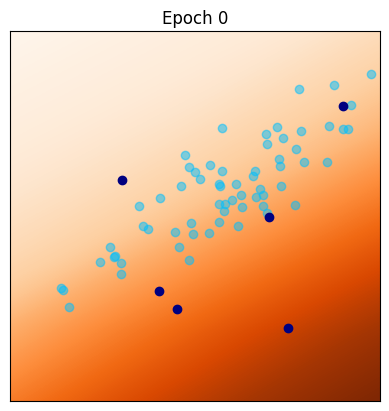

[1/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[2/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[3/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[4/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[5/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[6/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[7/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[8/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[9/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[10/100] 	Loss_D: 0.6188	Loss_G: -0.0018


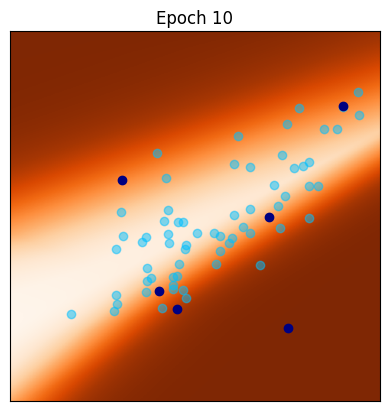

[11/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[12/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[13/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[14/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[15/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[16/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[17/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[18/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[19/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[20/100] 	Loss_D: 0.6188	Loss_G: -0.0018


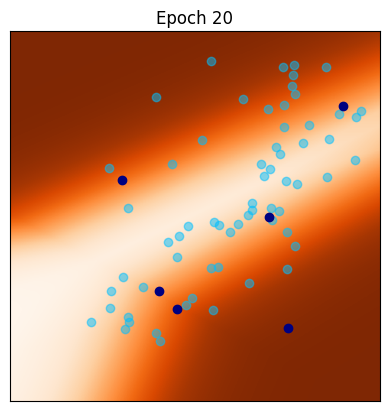

[21/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[22/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[23/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[24/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[25/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[26/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[27/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[28/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[29/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[30/100] 	Loss_D: 0.6188	Loss_G: -0.0018


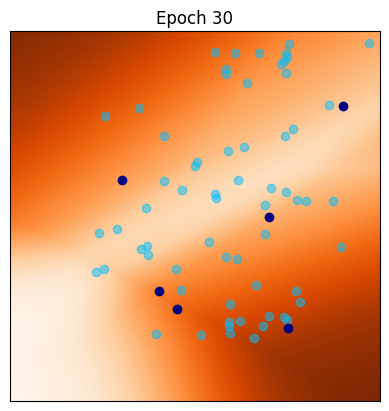

[31/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[32/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[33/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[34/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[35/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[36/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[37/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[38/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[39/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[40/100] 	Loss_D: 0.6188	Loss_G: -0.0018


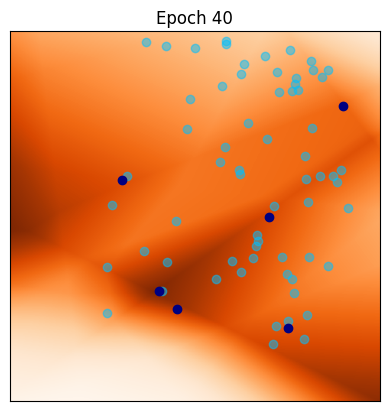

[41/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[42/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[43/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[44/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[45/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[46/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[47/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[48/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[49/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[50/100] 	Loss_D: 0.6188	Loss_G: -0.0018


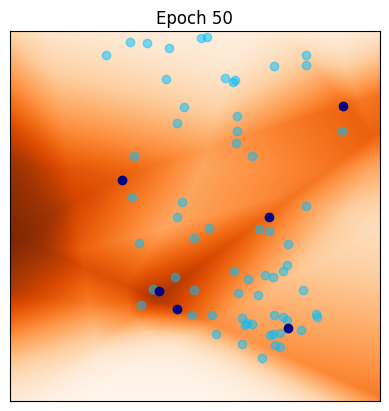

[51/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[52/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[53/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[54/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[55/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[56/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[57/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[58/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[59/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[60/100] 	Loss_D: 0.6188	Loss_G: -0.0018


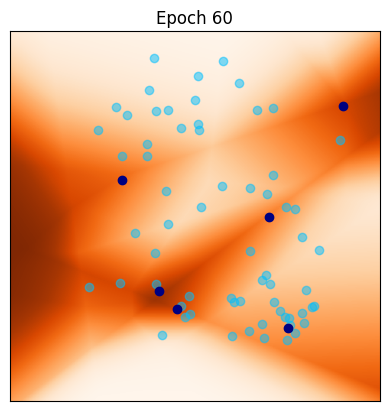

[61/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[62/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[63/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[64/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[65/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[66/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[67/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[68/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[69/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[70/100] 	Loss_D: 0.6188	Loss_G: -0.0018


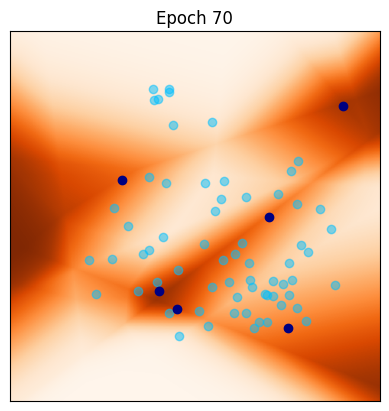

[71/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[72/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[73/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[74/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[75/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[76/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[77/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[78/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[79/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[80/100] 	Loss_D: 0.6188	Loss_G: -0.0018


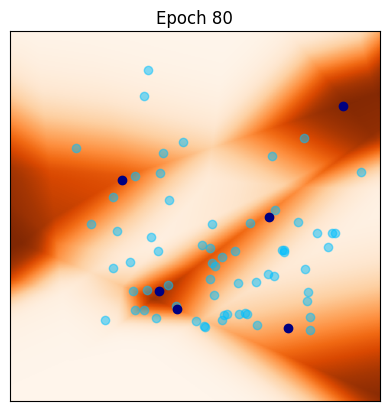

[81/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[82/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[83/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[84/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[85/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[86/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[87/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[88/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[89/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[90/100] 	Loss_D: 0.6188	Loss_G: -0.0018


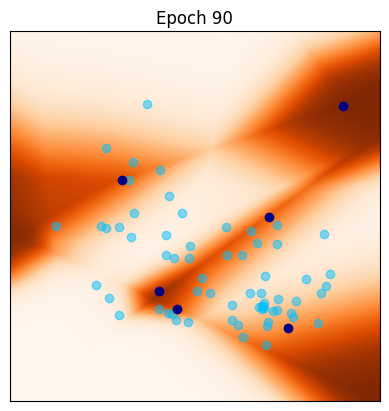

[91/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[92/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[93/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[94/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[95/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[96/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[97/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[98/100] 	Loss_D: 0.6188	Loss_G: -0.0018
[99/100] 	Loss_D: 0.6188	Loss_G: -0.0018


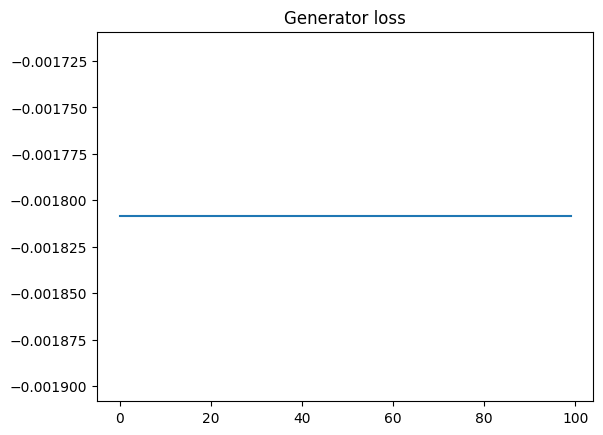

In [20]:
lr = 0.002   # learning rate for generator
lrdisc = 0.002   # learning rate for generator

## parameters for training
n_epochs = 100
niterD=100
niterG=1

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

Glosses = []
Dlosses = []

iter_display = 10

# Main loop
for epoch in range(n_epochs):

    ############################
    ### Train discriminator (niterD iterations)
    ############################
    for iter in range(0,niterD):
        D.zero_grad()

        # Train with real data
        real_data = y.to(device)  # Assuming 'y' is the batch of real data
        label_real = torch.full((real_data.size(0), 1), 1., device=device)
        output_real = D(real_data)
        lossD_real = criterion(output_real, label_real)

        # Train with fake data
        noise = torch.randn(real_data.size(0), n_in, device=device)
        fake_data = G(noise).detach()  # detach to avoid training G on these labels
        label_fake = torch.full((fake_data.size(0), 1), 0., device=device)
        output_fake = D(fake_data)
        lossD_fake = criterion(output_fake, label_fake)

        # Combine losses
        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimD.step()

    ############################
    ### Train generator (niterG iterations)
    ############################
    for iter in range(0,niterG):
        G.zero_grad()

        noise = torch.randn(b, n_in, device=device)
        fake_data = G(noise)
        label = torch.full((fake_data.size(0), 1), 1., device=device)  # Generator tries to fool the discriminator
        output = D(fake_data)
        lossG = criterion(output, label)
        lossG.backward()
        optimG.step()


    # Output training stats
    print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f'
      % (epoch, n_epochs, Dloss.item(), Gloss.item()))
    Glosses.append(Gloss.item())
    Dlosses.append(-Dloss.item())


    if(epoch % iter_display == 0):
        Dxgrid = sig(D(xgrid)).detach().cpu().numpy().reshape(nr,nc)
        z = torch.randn(b, 1, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Epoch '+str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()

# Save final generator for later use
gan = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
gan.load_state_dict(G.state_dict())

### Plot the evolution of the discriminator loss ###
plt.figure(dpi=100)
plt.plot(Glosses)
plt.title('Generator loss')
plt.show()